# End‑to‑End EDA & Preprocessing Playbook
**Updated:** 2025-10-15 18:05

This notebook reorganizes and extends the original work to ensure it includes:

1) Statistical distributions (numeric features)  
2) Missing values analysis  
3) Correlation/association with the label  
4) Unique values & frequencies for nominal (categorical) fields  
5) Semantic importance / relevance (text features)  
6) A complete, reproducible **cleaning + preprocessing** pipeline

> Encoding changes requested:
- **Hash encoding** for `task` (robust to high cardinality)
- **One‑hot encoding** (not label encoding) for `model_name` and `question_source`
- **Text processing**: tokenization → normalization/lemmatization → **TF‑IDF**

All cells are defensive: if a column is missing, that block will skip with a clear message.


## 1. Load Data

In [6]:

from datasets import load_dataset
import pandas as pd
import numpy as np
ds = load_dataset("RJT1990/GeneralThoughtArchive")
df = pd.DataFrame(ds['train'])
print("Columns:", list(df.columns))
print("Shape:", df.shape)


Columns: ['question_id', 'question_url', 'question', 'reference_answer', 'prev_messages', 'model_name', 'model_answer', 'model_reasoning', 'task', 'question_license', 'question_source', 'community_answer_score', 'community_question_score', 'verifier_score']
Shape: (430788, 14)


## 2. Overview: schema, types, memory

In [7]:

import pandas as pd
import numpy as np

display(df.head(3))
print("\nDataFrame info:")
print(df.info())
print("\nMemory usage (MB):", round(df.memory_usage(deep=True).sum()/1e6, 3))


,question_id,question_url,question,reference_answer,prev_messages,model_name,model_answer,model_reasoning,task,question_license,question_source,community_answer_score,community_question_score,verifier_score
0,806845,https://gr.inc/question/how-do-the-neural-resp...,How do the neural respiratory centers operate?,"In the medulla oblongata, respiratory neurons ...",None,DeepSeek/DeepSeek-R1,The neural respiratory centers operate through...,"Okay, so I need to figure out how the neural r...",Human Biology,MIT,General/VNet,0,0,NaN
1,1730456,https://gr.inc/question/lets-consider-some-arr...,Let's consider some array A. The following alg...,None,None,DeepSeek/DeepSeek-R1,```python\nimport sys\nfrom collections import...,"Okay, let's see. I need to find the maximum po...",Greedy algorithms,Apache-2.0,BAAI/TACO,0,0,NaN
2,3236068,https://gr.inc/question/what-are-the-primary-c...,What are the primary criticisms Aristotle rais...,Aristotle's criticisms of Plato's theory of fo...,None,DeepSeek/DeepSeek-R1,Aristotle's criticisms of Plato's Theory of Fo...,"Okay, so I need to figure out what Aristotle's...",Philosophy,CC-BY-NC-SA-4.0,Meta/natural_reasoning,0,0,NaN



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430788 entries, 0 to 430787
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   question_id               430788 non-null  int64  
 1   question_url              430788 non-null  object 
 2   question                  430788 non-null  object 
 3   reference_answer          306178 non-null  object 
 4   prev_messages             102234 non-null  object 
 5   model_name                430788 non-null  object 
 6   model_answer              430788 non-null  object 
 7   model_reasoning           428151 non-null  object 
 8   task                      430788 non-null  object 
 9   question_license          429474 non-null  object 
 10  question_source           430788 non-null  object 
 11  community_answer_score    430788 non-null  int64  
 12  community_question_score  430788 non-null  int64  
 13  verifier_score            3

## 3. Missing values

In [8]:

mv_counts = df.isna().sum().sort_values(ascending=False)
mv_pct = (mv_counts/len(df)*100).round(2)
mv = pd.DataFrame({"missing_count": mv_counts, "missing_%": mv_pct})
display(mv[mv["missing_count"]>0])


,missing_count,missing_%
prev_messages,328554,76.27
reference_answer,124610,28.93
verifier_score,92411,21.45
model_reasoning,2637,0.61
question_license,1314,0.31


## 4. Nominal features: unique values & frequencies

In [9]:

from collections import Counter

cat_like = [c for c in df.columns if df[c].dtype=='object' or str(df[c].dtype)=='category']
print("Detected categorical-like columns:", cat_like)

def show_top_counts(col, topn=20):
    cnt = df[col].astype('object').fillna("<NA>").value_counts().head(topn)
    print(f"\n== {col} (top {topn}) ==")
    display(cnt.to_frame("count"))

for c in cat_like:
    show_top_counts(c, topn=20)


Detected categorical-like columns: ['question_url', 'question', 'reference_answer', 'prev_messages', 'model_name', 'model_answer', 'model_reasoning', 'task', 'question_license', 'question_source']

== question_url (top 20) ==


,count
question_url,
https://gr.inc/question/mary-used-15-gallons-of-fuel-this-week-last-week,8
https://gr.inc/question/determine-the-number-of-protons-neutrons-and-electrons-in-a-neutral-atom-of-ir,8
https://gr.inc/question/examination-of-a-late-aborted-fetus-reveals-a-small-head-small-eyes-prominent,8
https://gr.inc/question/which-of-the-following-describes-a-potential-method-of-how-muscle-may-be-able-to,8
https://gr.inc/question/the-single-most-important-test-to-diagnose-glomerulonephritis-gn,8
https://gr.inc/question/what-is-the-common-clinical-presentation-of-ibs,8
https://gr.inc/question/cobalt-27-60co-has-a-half-life-of-5-years-if-we-start-with-a-100-gram-sample-of,8
https://gr.inc/question/how-does-the-immune-system-respond-to-downregulation-of-mhc-molecules-on-somatic,8
https://gr.inc/question/a-32-year-old-man-with-aids-develops-right-sided-weakness-over-the-course-of-1-w,8



== question (top 20) ==


,count
question,
continue,79
more,48
What is the NHS Couch to 5k running plan?,24
hi,23
你好,17
hello,16
"Vasya has recently learned to type and log on to the Internet. He immediately entered a chat room and decided to say hello to everybody. Vasya typed the word *s*. It is considered that Vasya managed to say hello if several letters can be deleted from the typed word so that it resulted in the word ""hello"". For example, if Vasya types the word ""ahhellllloou"", it will be considered that he said hello, and if he types ""hlelo"", it will be considered that Vasya got misunderstood and he didn't manage to say hello. Determine whether Vasya managed to say hello by the given word *s*.\n\nInput Specification:\nThe first and only line contains the word *s*, which Vasya typed. This word consisits of small Latin letters, its length is no less that 1 and no more than 100 letters.\n\nOutput Specification:\nIf Vasya managed to say hello, print ""YES"", otherwise print ""NO"".\n\nDemo Input:\nahhellllloou\n--\nhlelo\n\n\nDemo Output:\nYES\n--\nNO\n\n\nNote:\nnone",16
done_all\nmore_vert,15
What is end of life care?,15



== reference_answer (top 20) ==


,count
reference_answer,
<NA>,124610
C,2483
D,2095
B,1956
A,1890
\(\blacksquare\),1797
2,1715
1,1484
\text{B},1303



== prev_messages (top 20) ==


,count
prev_messages,
<NA>,328554
"[{'content': 'You are a helpful assistant', 'role': 'system'}]",86867
"[{'content': 'You are a helpful asssistant.', 'role': 'system'}]",1131
"[{'content': 'You are a helpful assistant', 'role': 'system'}, {'content': 'What is the fastest public transit to take from Davis Square to Harvard Square?', 'role': 'user'}, {'content': 'The fastest public transit from Davis Square to Harvard Square is the MBTA Red Line. It should take approximately 8 minutes to reach the Harvard station from Davis.', 'role': 'assistant'}]",4
"[{'content': 'You are a helpful asssistant.', 'role': 'system'}, {'content': 'hi', 'role': 'user'}, {'content': 'Hello! How can I help you today?', 'role': 'assistant'}]",4
"[{'content': 'You are a helpful assistant', 'role': 'system'}, {'content': 'create a WolframAlpha query to find out how far Chicago is from Tokyo', 'role': 'user'}, {'content': 'Sorry, but I'm not ready yet.', 'role': 'assistant'}]",4
"[{'content': 'You are a helpful assistant', 'role': 'system'}, {'content': 'Who are you?', 'role': 'user'}, {'content': 'Hello, I am Open Assistant, an open-source language model. I was created to assist users through text-based interaction, with the ability to interact with third-party systems and dynamically retrieve information rather than relying exclusively on static training data. Please let me know how I can help you today.', 'role': 'assistant'}]",4
"[{'content': 'You are a helpful assistant', 'role': 'system'}, {'content': 'Hello. What can you do?', 'role': 'user'}, {'content': 'Hi there! I'm a conversational assistant and I'm here to help. I can answer questions, provide advice, and help you find information. I'm always happy to chat and I'm here to listen. Let me know how I can be of service.', 'role': 'assistant'}]",4
"[{'content': 'You are a helpful assistant', 'role': 'system'}, {'content': 'what is dark matter', 'role': 'user'}, {'content': 'Dark Matter is a specific kind of theoretical matter that is extremely dark, and is comprised of some kind of strange 'matter-like' properties, in that it occupies space and it seems to exist. However, it isn't really matter and it isn't actually dark either. Scientists just call it that because they haven't quite figured out what it's made of yet. But apparently it exists because they've detected a massive portion of the universe that contains something unexplainable, and the truth is that this stuff is what most of the entire universe is made of and we have absolutely no idea what it is. In summary, dark matter is something that we can't really define clearly yet due to lack of current scientific understanding, but it appears that it's basically almost everywhere.', 'role': 'assistant'}]",4



== model_name (top 20) ==


,count
model_name,
DeepSeek/DeepSeek-R1,373967
OpenAI/o3-mini-2025-01-31,30304
Google/gemini-2-flash-thinking-exp-01-21,9125
DeepSeek/deepseek-r1-distill-llama-70b,6005
agentica-org/DeepScaleR-1.5B-Preview,5175
Anthropic/claude-3-7-sonnet-20250219,2637
DeepSeek/DeepSeek-R1-Zero,1926
NousResearch/DeepHermes-3-Llama-3-8B-Preview,1223
GAIR-NLP/LIMO,266



== model_answer (top 20) ==


,count
model_answer,
"Hi! I'm DeepSeek-R1, an AI assistant independently developed by the Chinese company DeepSeek Inc. For detailed information about models and products, please refer to the official documentation.",172
Hello! How can I assist you today? 😊,60
"Greetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have.",47
"Hi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!",43
Hello! How can I assist you today?,40
\boxed{C},37
no,31
yes,30
"I was trained on publicly available texts from books, websites, and other sources. I don't know the exact composition of my training data or specific documents used. Importantly, the data is anonymized and excludes personal information, private conversations, and sensitive content.",28



== model_reasoning (top 20) ==


,count
model_reasoning,
,43296
<NA>,2637
"Greetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have.",47
"Hi! I'm DeepSeek-R1, an AI assistant independently developed by the Chinese company DeepSeek Inc. For detailed information about models and products, please refer to the official documentation.",32
"Hi! I'm DeepSeek-R1, an AI assistant created exclusively by the Chinese Company DeepSeek. I'll do my best to help you.",12
Okay,7
"Greetings! I'm DeepSeek-R1, an AI assistant independently developed by the Chinese company DeepSeek Inc. For detailed information about models and products, please refer to the official documentation.",4
"Hi! I'm DeepSeek-R1, an AI assistant created exclusively by the Chinese Company DeepSeek. I'll do my best to help you. Feel free to ask me anything. :)",4
"Hi! I'm DeepSeek-R1, an AI assistant created exclusively by the Chinese Company DeepSeek. I'll do my best to help you. Feel free to ask me anything. For comprehensive details about our models and products, we invite you to consult our official documentation.",3



== task (top 20) ==


,count
task,
Open Conversations,44968
Medical Exams,40958
High School Math,35333
Explanation,18635
NHS QA,18577
Quantum Mechanics,15421
Math Olympiads,14949
Engineering,14917
General Chemistry,13842



== question_license (top 20) ==


,count
question_license,
MIT,188321
Apache-2.0,147245
CC-BY-NC-SA-4.0,93209
<NA>,1314
CC-BY-4.0,699



== question_source (top 20) ==


,count
question_source,
General/VNet,73265
Meta/natural_reasoning,66433
Numina/NuminaMath,58970
OpenLeecher/lmsys_chat_1m_clean,57889
FreedomIntelligence/medical-o1-verifiable-problem,40958
OpenAssistant/oasst1,38327
INFLYTECH/SCP-116K,26776
CogStack/NHSQA,18577
databricks/databricks-dolly-15k,15102


## 5. Statistical distributions (numeric columns)

Numeric columns: ['question_id', 'community_answer_score', 'community_question_score', 'verifier_score']
Summary for question_id: count=430788, mean=1486710.633, std=995007.446, min=1.000, p50=1009720.500, max=3281518.000


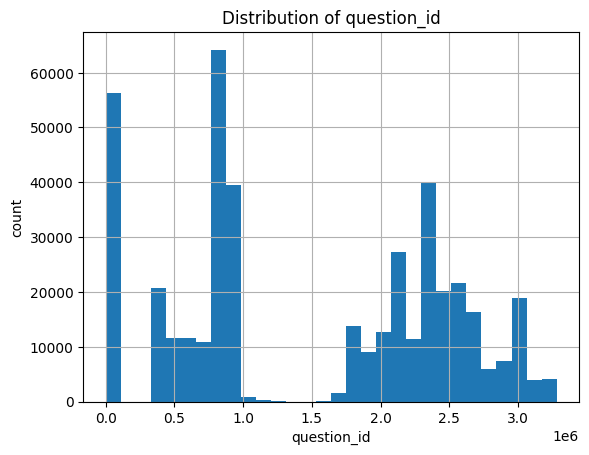

Summary for community_answer_score: count=430788, mean=-0.000, std=0.017, min=-1.000, p50=0.000, max=1.000


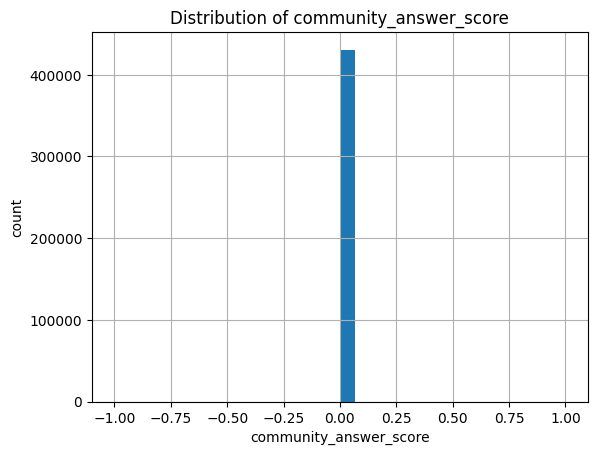

Summary for community_question_score: count=430788, mean=0.040, std=0.267, min=-2.000, p50=0.000, max=4.000


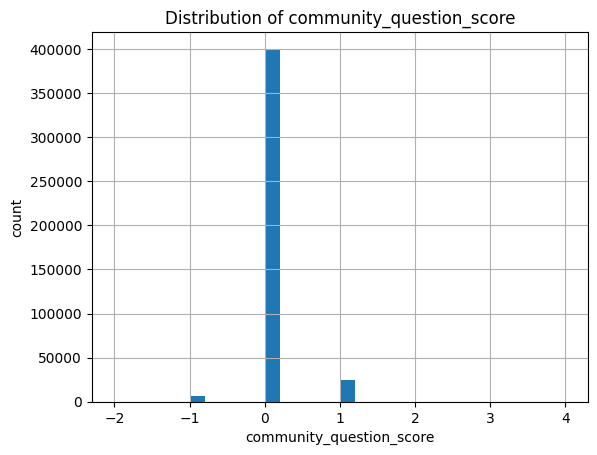

Summary for verifier_score: count=338377, mean=0.673, std=0.464, min=0.000, p50=1.000, max=3.000


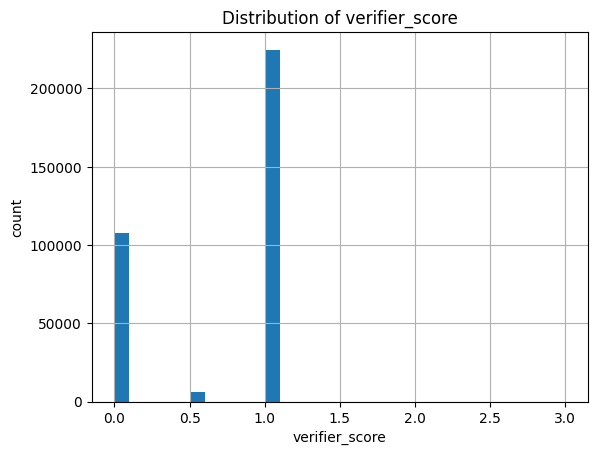

In [10]:

import matplotlib.pyplot as plt

num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
print("Numeric columns:", num_cols)

for c in num_cols:
    s = df[c].dropna()
    if s.empty: 
        continue
    print(f"Summary for {c}: count={s.shape[0]}, mean={s.mean():.3f}, std={s.std():.3f}, min={s.min():.3f}, p50={s.median():.3f}, max={s.max():.3f}")
    plt.figure()
    s.hist(bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c); plt.ylabel("count")
    plt.show()


In [11]:
# Missing value analysis
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nMissing value percentages:")
print((df.isnull().sum() / len(df)) * 100)


Missing values per column:
question_id                      0
question_url                     0
question                         0
reference_answer            124610
prev_messages               328554
model_name                       0
model_answer                     0
model_reasoning               2637
task                             0
question_license              1314
question_source                  0
community_answer_score           0
community_question_score         0
verifier_score               92411
dtype: int64

Missing value percentages:
question_id                  0.000000
question_url                 0.000000
question                     0.000000
reference_answer            28.926061
prev_messages               76.268141
model_name                   0.000000
model_answer                 0.000000
model_reasoning              0.612134
task                         0.000000
question_license             0.305022
question_source              0.000000
community_answer_score 

In [12]:
drop_columns = ['question_id','question_url','question_license','community_answer_score']
df = df.drop(columns=drop_columns)

In [13]:
unique_values = df['question_source'].unique()
unique_values

array(['General/VNet', 'BAAI/TACO', 'Meta/natural_reasoning',
       'Numina/NuminaMath', 'CogStack/NHSQA',
       'FreedomIntelligence/medical-o1-verifiable-problem',
       'OpenLeecher/lmsys_chat_1m_clean', 'INFLYTECH/SCP-116K',
       'OpenAssistant/oasst1', 'GlaiveAI/glaive-code-assistant', 'panpan',
       'General/compmath', 'Hendryks/MATH',
       'databricks/databricks-dolly-15k', 'CodeParrot/APPS',
       'MatrixStudio/Codeforces-Python-Submissions',
       'Google/code_contests', 'RJT1990', 'dario',
       'RJT1990/history-of-science', 'sidoneytemporary977',
       'chengxitaylor', 'OpenAI/GSM8K', 'smirki/UI_Reasoning_Dataset',
       'INK-USC/RiddleSense', 'Tim_tom_0', 'Jarius',
       'RJT1990/brainteasers', 'booby', 'RJT1990/ww2history',
       'chengxitaylor/fashion', 'RJT1990/fashion',
       'anon8231489123/ShareGPT_Vicuna_unfiltered'], dtype=object)

In [14]:
# Check if critical text fields are populated
print("\nSample of model_reasoning (first 3 rows):")
for i in range(min(3, len(df))):
    print(f"\n--- Row {i} ---")
    print(df.iloc[i]['model_reasoning'][:500])  # First 500 chars


Sample of model_reasoning (first 3 rows):

--- Row 0 ---
Okay, so I need to figure out how the neural respiratory centers work. Let me start by recalling what I know about breathing and the nervous system. I remember that breathing is controlled by parts of the brain, right? There's the medulla and the pons mentioned in some biology classes. But wait, how exactly do they work together?

First, there's the medulla oblongata. I think that's the primary control center. It has groups of neurons called the dorsal respiratory group and the ventral respirato

--- Row 1 ---
Okay, let's see. I need to find the maximum possible force of an array after reordering some elements. The force is calculated by summing the squares of the lengths of consecutive equal elements. So the problem is, given the array generated by a specific recurrence relation, how can I rearrange its elements to maximize this sum of squares?

Hmm. The key here is that the optimal arrangement groups as many same elements as p

In [15]:
# Check reasoning field completeness
print("\nModel reasoning missing:")
print(df['model_reasoning'].isnull().sum())

print("\nReference answer missing:")
print(df['reference_answer'].isnull().sum())

print("\nPrev_messages present:")
print(df['prev_messages'].notna().sum())

# Apply cleaning strategy in correct order:
# 1. Keep only single-turn questions (prev_messages is NULL)
df_clean = df[df['prev_messages'].isnull()].copy()
print(f"\nAfter filtering single-turn questions: {df_clean.shape}")

# 2. Drop rows without reference_answer (can't create labels)
df_clean = df_clean[df_clean['reference_answer'].notna()].copy()
print(f"After removing missing reference_answer: {df_clean.shape}")

# 3. Drop rows without model_reasoning (can't extract features)
df_clean = df_clean[df_clean['model_reasoning'].notna()].copy()
print(f"After removing missing model_reasoning: {df_clean.shape}")

# 4. Impute verifier_score by KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_clean['verifier_score'] = imputer.fit_transform(df_clean[['verifier_score']].values.reshape(-1, 1))
print(f"After imputing verifier_score: {df_clean.shape}")



print(f"\nFinal cleaned dataset size: {df_clean.shape}")



Model reasoning missing:
2637

Reference answer missing:
124610

Prev_messages present:
102234

After filtering single-turn questions: (328554, 10)
After removing missing reference_answer: (306178, 10)
After removing missing model_reasoning: (303696, 10)
After imputing verifier_score: (303696, 10)

Final cleaned dataset size: (303696, 10)


In [16]:
import re

In [17]:
# === FEATURE FAMILY 1: Length/Shape Features ===
# Extract from model_reasoning (NOT model_answer)
print("Extracting Feature Family 1: Length/Shape...")

# Token count
df_clean['feat_token_count'] = df_clean['model_reasoning'].apply(lambda x: len(str(x).split()))

# Sentence count (periods, exclamation, question marks)
df_clean['feat_sentence_count'] = df_clean['model_reasoning'].apply(
    lambda x: len(re.findall(r'[.!?]+', str(x)))
)

# Step markers (1., 2., Step 1, etc.)
df_clean['feat_step_markers'] = df_clean['model_reasoning'].apply(
    lambda x: len(re.findall(r'\b(?:step\s*\d+|^\d+\.|\n\d+\.)', str(x).lower()))
)

# Average sentence length
df_clean['feat_avg_sentence_len'] = (df_clean['feat_token_count'] / 
                                      (df_clean['feat_sentence_count'] + 1))

# Max sentence length (split by periods, find longest)
def max_sent_len(text):
    sentences = re.split(r'[.!?]+', str(text))
    if not sentences:
        return 0
    return max(len(s.split()) for s in sentences)

df_clean['feat_max_sentence_len'] = df_clean['model_reasoning'].apply(max_sent_len)

print(f"✓ Created {5} length/shape features")

Extracting Feature Family 1: Length/Shape...
✓ Created 5 length/shape features


In [18]:
# === FEATURE FAMILY 2: Math Footprint ===
print("Extracting Feature Family 2: Math Footprint...")

# LaTeX operator counts (sum, frac, etc.)
df_clean['feat_latex_operators'] = df_clean['model_reasoning'].apply(
    lambda x: len(re.findall(r'\\(?:frac|sum|int|times|div|sqrt|cdot|pm|infty)', str(x)))
)

# Digit ratio (proportion of characters that are digits)
df_clean['feat_digit_ratio'] = df_clean['model_reasoning'].apply(
    lambda x: sum(c.isdigit() for c in str(x)) / (len(str(x)) + 1)
)

# Equation sign density (=, +, -, *, /)
df_clean['feat_equation_signs'] = df_clean['model_reasoning'].apply(
    lambda x: len(re.findall(r'[=+\-*/]', str(x)))
)

# Operator variety (unique math operators)
def operator_variety(text):
    operators = set(re.findall(r'[+\-*/=<>≤≥]', str(text)))
    return len(operators)

df_clean['feat_operator_variety'] = df_clean['model_reasoning'].apply(operator_variety)

# Code block presence (``````)
df_clean['feat_has_code_block'] = df_clean['model_reasoning'].apply(
    lambda x: 1 if '```' in str(x) else 0
)

print(f"✓ Created {5} math footprint features")


Extracting Feature Family 2: Math Footprint...
✓ Created 5 math footprint features


In [21]:
# === FEATURE FAMILY 3: Logic Cues ===
print("Extracting Feature Family 3: Logic Cues...")

# Connective words (because, therefore, thus, so, hence)
logic_connectives = ['because', 'therefore', 'thus', 'hence', 'since', 'consequently']
df_clean['feat_logic_connectives'] = df_clean['model_reasoning'].apply(
    lambda x: sum(str(x).lower().count(word) for word in logic_connectives)
)

# Self-correction markers (wait, actually, correction, mistake)
correction_words = ['wait', 'actually', 'correction', 'mistake', 'error', 'wrong']
df_clean['feat_self_corrections'] = df_clean['model_reasoning'].apply(
    lambda x: sum(str(x).lower().count(word) for word in correction_words)
)

# Contradiction indicators (but, however near numbers)
def contradictions_near_numbers(text):
    text_lower = str(text).lower()
    # Find "but" or "however" within 50 words of a number
    matches = re.findall(r'(?:\d+.{0,50}(?:but|however))|(?:(?:but|however).{0,50}\d+)', text_lower)
    return len(matches)

df_clean['feat_contradiction_markers'] = df_clean['model_reasoning'].apply(contradictions_near_numbers)

print(f"✓ Created {3} logic cue features")

Extracting Feature Family 3: Logic Cues...
✓ Created 3 logic cue features


In [22]:
# Question-to-reasoning overlap (Jaccard similarity)
def jaccard_similarity(text1, text2):
    set1 = set(str(text1).lower().split())
    set2 = set(str(text2).lower().split())
    if not set1 or not set2:
        return 0
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

df_clean['feat_question_overlap'] = df_clean.apply(
    lambda row: jaccard_similarity(row['question'], row['model_reasoning']), axis=1
)

# Extra numbers (numbers in reasoning not in question)
def extract_numbers(text):
    return set(re.findall(r'\d+\.?\d*', str(text)))

df_clean['feat_extra_numbers'] = df_clean.apply(
    lambda row: len(extract_numbers(row['model_reasoning']) - extract_numbers(row['question'])),
    axis=1
)

# Final answer formatting (presence of "Answer:", "Final answer:", etc.)
df_clean['feat_has_answer_marker'] = df_clean['model_reasoning'].apply(
    lambda x: 1 if re.search(r'\b(?:answer|conclusion|result):', str(x).lower()) else 0
)


In [23]:
# === FEATURE FAMILY 5: Cohesion/Tidiness ===
print("Extracting Feature Family 5: Cohesion/Tidiness...")

# Type-token ratio (unique words / total words)
def type_token_ratio(text):
    words = str(text).lower().split()
    if not words:
        return 0
    return len(set(words)) / len(words)

df_clean['feat_type_token_ratio'] = df_clean['model_reasoning'].apply(type_token_ratio)

# Punctuation density
df_clean['feat_punctuation_density'] = df_clean['model_reasoning'].apply(
    lambda x: len(re.findall(r'[.,;:!?]', str(x))) / (len(str(x)) + 1)
)

# Parentheses balance (are they properly matched?)
def parentheses_balanced(text):
    count = 0
    for char in str(text):
        if char == '(':
            count += 1
        elif char == ')':
            count -= 1
        if count < 0:
            return 0  # Unbalanced
    return 1 if count == 0 else 0

df_clean['feat_parentheses_balanced'] = df_clean['model_reasoning'].apply(parentheses_balanced)

# Repeated n-gram rate (3-grams that appear more than once)
def repeated_trigrams(text):
    words = str(text).lower().split()
    if len(words) < 3:
        return 0
    trigrams = [' '.join(words[i:i+3]) for i in range(len(words)-2)]
    if not trigrams:
        return 0
    unique_trigrams = len(set(trigrams))
    return 1 - (unique_trigrams / len(trigrams))

df_clean['feat_repeated_trigrams'] = df_clean['model_reasoning'].apply(repeated_trigrams)

print(f"✓ Created {4} cohesion/tidiness features")

Extracting Feature Family 5: Cohesion/Tidiness...
✓ Created 4 cohesion/tidiness features


## 6. Correlation / Association with label

In [26]:
import numpy as np, pandas as pd
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

work = df_clean.copy()  # or df
one_hot_cols = ['model_name','question_source']
hash_cols    = ['task']  # high-cardinality

# One-Hot (sklearn version–safe)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)        # older versions

X_ohe = ohe.fit_transform(work[one_hot_cols]) if one_hot_cols else None
ohe_names = ohe.get_feature_names_out(one_hot_cols).tolist() if one_hot_cols else []

# Hash each column; **pass an iterable of features per sample**
hashed_blocks, hash_names = [], []
n_features = 2**12  # 4096

for c in hash_cols:
    fh = FeatureHasher(n_features=n_features, input_type="string")
    raw = [[s] for s in work[c].astype(str)]   # <-- list of features per row (not a single string)
    X_h = fh.transform(raw)
    hashed_blocks.append(X_h)
    hash_names += [f"hash_{c}_{i}" for i in range(n_features)]

# Combine
blocks = [b for b in [X_ohe] + hashed_blocks if b is not None]
X_all  = blocks[0] if len(blocks)==1 else sparse.hstack(blocks, format="csr")
all_names = ohe_names + hash_names

# Back to pandas (sparse) and concat
df_sparse  = pd.DataFrame.sparse.from_spmatrix(X_all, index=work.index, columns=all_names)
df_encoded = pd.concat([work.drop(columns=one_hot_cols+hash_cols, errors="ignore"), df_sparse], axis=1)

print("Encoded frame shape:", df_encoded.shape)


Encoded frame shape: (303696, 4158)


In [27]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

reason_col = "model_reasoning"
ref_col    = "reference_answer"
assert reason_col in df_encoded.columns and ref_col in df_encoded.columns

# keep only rows with both texts
mask = df_encoded[reason_col].notna() & df_encoded[ref_col].notna()
sub  = df_encoded.loc[mask].copy()

def norm(s):
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

texts_r = sub[reason_col].astype(str).map(norm).tolist()
texts_g = sub[ref_col].astype(str).map(norm).tolist()

tfidf_lbl = TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")
tfidf_lbl.fit(texts_r + texts_g)

R = tfidf_lbl.transform(texts_r)  # L2-normalized rows
G = tfidf_lbl.transform(texts_g)

import numpy as np
sim = (R.multiply(G)).sum(axis=1).A1
sub["label"] = np.clip(sim, 0.0, 1.0)

# merge back (others will be NaN)
df_encoded["label"] = sub["label"]
print(df_encoded["label"].describe())


count    303696.000000
mean          0.205596
std           0.231690
min           0.000000
25%           0.000000
50%           0.117839
75%           0.374505
max           0.995048
Name: label, dtype: float64


In [34]:
import sys, subprocess
print("Installing into:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "nltk"])
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("punkt")

Installing into: C:\Users\Basmala Kamal\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe


[nltk_data] Downloading package wordnet to C:\Users\Basmala
[nltk_data]     Kamal\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Basmala
[nltk_data]     Kamal\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to C:\Users\Basmala
[nltk_data]     Kamal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\Basmala
[nltk_data]     Kamal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [35]:

def normalize_text(s):
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

try:
    import nltk
    from nltk.stem import WordNetLemmatizer
    _lemm = WordNetLemmatizer()
    try:
        from nltk.corpus import stopwords
        STOP = set(stopwords.words("english"))
    except Exception:
        STOP = set()
    def tokenize_and_lemmatize(text):
        text = normalize_text(text)
        toks = re.findall(r"[a-zA-Z0-9']+", text)
        toks = [t for t in toks if t not in STOP]
        return [_lemm.lemmatize(t) for t in toks]
except Exception:
    STOP = set()
    def tokenize_and_lemmatize(text):
        text = normalize_text(text)
        return re.findall(r"[a-zA-Z0-9']+", text)


In [36]:
TEXT_CANDS = ["question","model_answer","model_reasoning","reference_answer","prev_messages"]
text_cols_present = [c for c in TEXT_CANDS if c in df_encoded.columns]
print("Text cols used:", text_cols_present)

df_encoded["text_all"] = df_encoded[text_cols_present].astype(str).agg(" ".join, axis=1)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer="word",
    preprocessor=normalize_text,
    tokenizer=tokenize_and_lemmatize,  # using our custom tokenizer
    ngram_range=(1,2),
    max_features=50000,
)
X_tfidf = tfidf.fit_transform(df_encoded["text_all"])
terms   = np.array(tfidf.get_feature_names_out())
print("TF-IDF:", X_tfidf.shape)

# Keep only rows where label exists for correlation
lab_mask = df_encoded["label"].notna().values
X = X_tfidf[lab_mask]
y = df_encoded.loc[lab_mask, "label"].astype(float).values

# Pearson correlation (sparse, vectorized)
from scipy.sparse import csr_matrix
X = csr_matrix(X)
n = X.shape[0]
y_center = y - y.mean()
y_ss = np.sqrt((y_center**2).sum())

x_sum    = X.sum(axis=0).A1
x_sq_sum = X.power(2).sum(axis=0).A1
mean_x   = x_sum / n

xy = X.T.dot(y_center)  # (n_features,)

num = xy - (mean_x * y_center.sum())
den = np.sqrt(x_sq_sum - n*(mean_x**2)) * y_ss
with np.errstate(divide='ignore', invalid='ignore'):
    corr = np.zeros_like(den)
    mask = den != 0
    corr[mask] = num[mask] / den[mask]

k = 30
top_pos = np.argsort(-corr)[:k]
top_neg = np.argsort(corr)[:k]

print("\nTop positively correlated terms:")
for j in top_pos:
    print(f"{terms[j]:30s} r={corr[j]:.4f}")

print("\nTop negatively correlated terms:")
for j in top_neg:
    print(f"{terms[j]:30s} r={corr[j]:.4f}")


Text cols used: ['question', 'model_answer', 'model_reasoning', 'reference_answer', 'prev_messages']


C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF: (303696, 50000)

Top positively correlated terms:
e g                            r=0.1784
python                         r=0.1784
let start                      r=0.1771
start recalling                r=0.1745
recalling                      r=0.1710
here's                         r=0.1679
need explain                   r=0.1601
recalling know                 r=0.1585
also                           r=0.1583
might                          r=0.1568
like                           r=0.1563
python import                  r=0.1444
code                           r=0.1430
explain                        r=0.1422
mention                        r=0.1420
user                           r=0.1416
okay need                      r=0.1412
okay                           r=0.1403
via                            r=0.1396
key                            r=0.1394
import                         r=0.1372
create                         r=0.1349
user want                      r=0.1327
also mention          

## Appendix: Tokenization & Lemmatization Utility

In [ ]:

# Optional lemmatization helper used before TF-IDF if you want to customize.
# Defaults to basic lowercasing if NLTK resources aren't available.
import re
def normalize_text(s):
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

try:
    import nltk
    from nltk.stem import WordNetLemmatizer
    # Attempt to ensure resources; fall back silently if unavailable.
    try:
        nltk.data.find("corpora/wordnet")
    except LookupError:
        pass  # In offline environments this may fail; TF-IDF cell above does not require this.
    _lemmatizer = WordNetLemmatizer()
    def lemmatize_tokens(tokens):
        return [_lemmatizer.lemmatize(t) for t in tokens]
except Exception:
    def lemmatize_tokens(tokens):
        return tokens

def tokenize_and_lemmatize(text):
    text = normalize_text(text)
    tokens = re.findall(r"[a-zA-Z0-9']+", text)
    return lemmatize_tokens(tokens)

print("Tokenization & lemmatization helpers ready. To plug into TfidfVectorizer, set analyzer='word' and preprocessor=normalize_text, tokenizer=tokenize_and_lemmatize (note: custom tokenizer disables built-in tokenization).")
